In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=e916047a66dfe9cbe82894cd451b2de4969aee9c66e6da8ad2de2c28bf7bb18d
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 111.9 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [ ]:
!kill -9 -1

In [2]:
!pip install -q pyyaml h5py

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Lambda, Input, AveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import tensorflow as tf 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import random
#import cv2
import os

In [115]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

device = tf.test.gpu_device_name()
device

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 406251721776596939
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2382369384559023624
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


'/device:GPU:0'

In [116]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# Changing directory to images
os.chdir("/content/drive/MyDrive/Data Analysis Bootcamp/Resources")

In [8]:
# Check Classes 
image_names=list(os.listdir("Database"))
image_names.sort()
print(image_names)
class_number = len(image_names)

['COVID19', 'NORMAL', 'Viral_Pneumonia']


In [9]:
# Directory with Atelectasis
#atele_dir=os.path.join("Database/COVID19")
#df =pd.DataFrame.from_records({"file_name":os.listdir(atele_dir),"condition": "Covid"})
#for f in image_names[1:]:
#    folder_path="Database/" + f
#    temp_df= pd.DataFrame.from_records({"file_name":os.listdir(folder_path),"condition": f })
#    df=df.append(temp_df)
    
#df["condition"].value_counts()

In [10]:
#Exporting Label CSV
#df.to_csv("Labels.csv")

In [11]:
# balance classes - random Random Sampling No_Finding
#df_no_finding = df[df["condition"]=="No_Finding"].sample(n=150, random_state=42)
#df_balanced = df[df["condition"]!="No_Finding"].append(df_no_finding)
#df_balanced["condition"].value_counts()

In [12]:
#df_balanced["file_name"] = "Resources/Images/Classes/"+df_balanced["file_name"]

In [118]:
# Settings
batch_size = 256
img_height, img_width = 200,200
epochs = 100
data_dir = "Database/"

In [119]:
# Rescale images 
datagen= ImageDataGenerator(rescale=1/255,validation_split=.3,rotation_range=20,
                           shear_range=.2,width_shift_range=0.1,height_shift_range=0.1,zoom_range=0.2)

# Flow training images in batches of batch_size using train_data 
train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=True, 
                seed=30)


datagen2=ImageDataGenerator(rescale=1/255,validation_split=.3)

val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=True, 
                seed=30)

## For evaluation
eval_train_ds= datagen.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                subset="training",
                class_mode="categorical", 
                classes= image_names,
                shuffle=False, 
                seed=30)

eval_val_ds=datagen2.flow_from_directory(
                data_dir,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                classes= image_names,
                class_mode="categorical", 
                subset="validation", 
                shuffle=False, 
                seed=30)

Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.
Found 2893 images belonging to 3 classes.
Found 1238 images belonging to 3 classes.


In [ ]:
# Base model

with tf.device(device):
  Base_model = tf.keras.Sequential([
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Conv2D(32, 3, activation='relu'),
                               MaxPooling2D(),
                               Dense(img_height, activation='relu'),
                               Flatten(),
                               Dense(class_number, activation='softmax')
                               ])
  Base_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
  )

  Base_history = Base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
  )

  plt.plot(Base_history.history['accuracy'])
  plt.plot(Base_history.history['val_accuracy'])
  plt.title('Base model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.0600 - accuracy: 0.4372  

In [ ]:
Base_model.save('Base_model')

Base_hist_df = pd.DataFrame(Base_history.history) 
Base_hist_df.to_csv('Base_model/history.csv')

tf.keras.utils.plot_model(
    Base_model, to_file='Base_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)



Epoch 1/100
12/12 [==============================] - 106s 8s/step - loss: 1.2812 - accuracy: 0.4857 - val_loss: 0.3921 - val_accuracy: 0.8271
Epoch 2/100
12/12 [==============================] - 92s 8s/step - loss: 0.3767 - accuracy: 0.8558 - val_loss: 0.3139 - val_accuracy: 0.8732
Epoch 3/100
12/12 [==============================] - 92s 8s/step - loss: 0.2804 - accuracy: 0.9012 - val_loss: 0.2897 - val_accuracy: 0.8845
Epoch 4/100
12/12 [==============================] - 93s 8s/step - loss: 0.2401 - accuracy: 0.9188 - val_loss: 0.2959 - val_accuracy: 0.8893
Epoch 5/100
12/12 [==============================] - 92s 8s/step - loss: 0.2147 - accuracy: 0.9303 - val_loss: 0.2659 - val_accuracy: 0.8982
Epoch 6/100
12/12 [==============================] - 93s 8s/step - loss: 0.2033 - accuracy: 0.9361 - val_loss: 0.2614 - val_accuracy: 0.8974
Epoch 7/100
12/12 [==============================] - 92s 8s/step - loss: 0.1842 - accuracy: 0.9415 - val_loss: 0.2362 - val_accuracy: 0.9079
Epoch 8/100


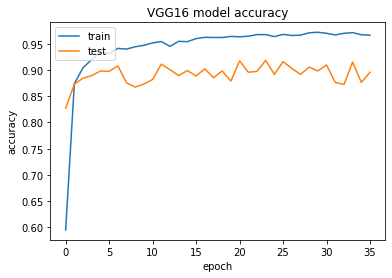

In [32]:
# VGG16 Model

VGG16_classifier=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier.layers:
    layer.trainable=False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

with tf.device(device):
  VGG16_model = tf.keras.Sequential([
                                     VGG16_classifier,
                                     #MaxPooling2D(),
                                     #Dense(img_height, activation='relu'),
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model_history = VGG16_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[callback]
      )
  plt.plot(VGG16_model_history.history['accuracy'])
  plt.plot(VGG16_model_history.history['val_accuracy'])
  plt.title('VGG16 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

In [ ]:
VGG16_model.save('VGG16_model')

VGG16_model_history_df = pd.DataFrame(VGG16_model_history.history) 
VGG16_model_history_df.to_csv('VGG16_model/history.csv')

tf.keras.utils.plot_model(
    VGG16_model, to_file='VGG16_model/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
Y_pred = VGG16_model.predict_generator(val_ds2, 1238 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('VGG16_model Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(val_ds2.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("VGG16_model/confusion_matrix.csv")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(val_ds2.class_indices.keys())
print(classification_report(val_ds2.classes, y_pred, target_names=target_names))

In [ ]:
#ResNet50 model

ResNet50_classifier=ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in ResNet50_classifier.layers:
    layer.trainable=False

with tf.device(device):
  ResNet50_model = tf.keras.Sequential([
                                     ResNet50_classifier,
                                     #MaxPooling2D(),
                                     #Dense(img_height*2, activation='relu'),
                                     #MaxPooling2D(),
                                     #Dense(img_height, activation='relu')
                                     Flatten(),
                                     Dense(class_number, activation='softmax')
                                     ])

  ResNet50_model.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  ResNet50_model_history = ResNet50_model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=20,
      verbose=1
      )
  plt.plot(ResNet50_model_history.history['accuracy'])
  plt.plot(ResNet50_model_history.history['val_accuracy'])
  plt.title('ResNet50 model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

Epoch 1/20
 8/12 [===================>..........] - ETA: 19s - loss: 7.6175 - accuracy: 0.3535

INFO:tensorflow:Assets written to: ResNet50_model_simple/assets


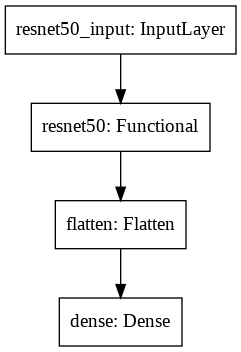

In [ ]:
ResNet50_model.save('ResNet50_model_simple')

ResNet50_model_history_df = pd.DataFrame(ResNet50_model_history.history) 
ResNet50_model_history_df.to_csv('ResNet50_model_simple/history.csv')

tf.keras.utils.plot_model(
    ResNet50_model, to_file='ResNet50_model_simple/architecture.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
Y_pred = ResNet50_model.predict(eval_val_ds, 1238 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('ResNet50_model_simple Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(eval_val_ds.classes, y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv("ResNet50_model_simple/confusion_matrix.csv")
print(conf_matrix)
print('\n')
print('Classification Report')
target_names = list(eval_val_ds.class_indices.keys())
print(classification_report(eval_val_ds.classes, y_pred, target_names=target_names))

ResNet50_model_simple Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_Pneumonia
true: COVID19                    375             5                     18
true: NORMAL                       3           387                     12
true: Viral_Pneumonia             11           100                    327


Classification Report
                 precision    recall  f1-score   support

        COVID19       0.96      0.94      0.95       398
         NORMAL       0.79      0.96      0.87       402
Viral_Pneumonia       0.92      0.75      0.82       438

       accuracy                           0.88      1238
      macro avg       0.89      0.88      0.88      1238
   weighted avg       0.89      0.88      0.88      1238



Epoch 1/100
12/12 [==============================] - 88s 7s/step - loss: 1.2859 - accuracy: 0.4789 - val_loss: 0.4380 - val_accuracy: 0.8126
Epoch 2/100
12/12 [==============================] - 86s 7s/step - loss: 0.5609 - accuracy: 0.7660 - val_loss: 0.3196 - val_accuracy: 0.8764
Epoch 3/100
12/12 [==============================] - 85s 7s/step - loss: 0.4207 - accuracy: 0.8257 - val_loss: 0.3371 - val_accuracy: 0.8740
Epoch 4/100
12/12 [==============================] - 86s 7s/step - loss: 0.3455 - accuracy: 0.8766 - val_loss: 0.3826 - val_accuracy: 0.8522
Epoch 5/100
12/12 [==============================] - 85s 7s/step - loss: 0.2937 - accuracy: 0.8897 - val_loss: 0.3600 - val_accuracy: 0.8611
Epoch 6/100
12/12 [==============================] - 86s 7s/step - loss: 0.2759 - accuracy: 0.9057 - val_loss: 0.3240 - val_accuracy: 0.8732
Epoch 7/100
12/12 [==============================] - 85s 7s/step - loss: 0.2705 - accuracy: 0.9016 - val_loss: 0.3305 - val_accuracy: 0.8716
Epoch 8/100
1

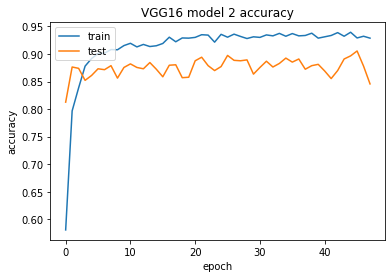

In [23]:
# VGG16 Model with Dropout

VGG16_classifier2=VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

for layer in VGG16_classifier2.layers:
    layer.trainable=False

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

with tf.device('/device:GPU:0'):
  VGG16_model2 = tf.keras.Sequential([
                                     VGG16_classifier2,
                                     #MaxPooling2D(),
                                     Flatten(),
                                     #Dense(img_height, activation='relu'),
                                     Dropout(0.75),
                                     Dense(class_number, activation='softmax')
                                     ])

  VGG16_model2.compile(
      optimizer='adam',
      loss=tf.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
      )
  
  VGG16_model2_history = VGG16_model2.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[callback]
      )
  plt.plot(VGG16_model2_history.history['accuracy'])
  plt.plot(VGG16_model2_history.history['val_accuracy'])
  plt.title('VGG16 model 2 accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()  

In [26]:
VGG16_model2_history_df = pd.DataFrame(VGG16_model2_history.history) 
VGG16_model2_history_df.to_csv('VGG16_model2.csv')

tf.keras.utils.plot_model(
    VGG16_model2, to_file='VGG16_model2.png', show_shapes=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

VGG16_model2.save('VGG16_model2')

INFO:tensorflow:Assets written to: VGG16_model2/assets


In [ ]:
val_ds

In [ ]:
labels

tf.math.confusion_matrix(
    labels, predictions, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)

In [127]:
#################################################################################################################################################################################
################################################################### Load Models #################################################################################################
#################################################################################################################################################################################
model_name = 'ResNet50_model'
new_model = tf.keras.models.load_model(model_name)

In [105]:
!ls

Base_model  Labels.csv	    ResNet50_model2  VGG16_model2
Database    ResNet50_model  VGG16_model


In [128]:
################ NORMAL

image_path = 'Database/NORMAL/NORMAL (1).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [129]:
image_path = 'Database/NORMAL/NORMAL (2).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [130]:
image_path = 'Database/NORMAL/NORMAL (3).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [134]:
############### VIRAL PNEUMONIA
ds=pd.DataFrame(columns=['col1', 'col2', 'col3'])

for i in range(1,501):
  #image_path = f'Database/Viral_Pneumonia/Viral Pneumonia ({i+700}).png' # 0, 242, 258 resnet50: 1
  #image_path = f'Database/COVID19/COVID-19 ({i+500}).png' # 132, 55, 313 resnet50: 1
  image_path = f'Database/NORMAL/NORMAL ({i}).png' # 0, 500, 0
  image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = new_model.predict(input_arr)
  preds=np.around(predictions, decimals=3)[0]
  ds.loc[i-1] = preds
  print(i)

m = np.zeros_like(ds.values)
m[np.arange(len(ds)), ds.values.argmax(1)] = 1

ds1 = pd.DataFrame(m, columns = ds.columns).astype(int)
ds1.sum()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


col1    500
col2      0
col3      0
dtype: int64

In [96]:
ds1[ds1['col1']==1]

,col1,col2,col3
3,1,0,0
4,1,0,0
5,1,0,0
15,1,0,0
21,1,0,0
...,...,...,...
436,1,0,0
440,1,0,0
447,1,0,0
463,1,0,0


In [136]:
image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (55).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [137]:
image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (35).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [138]:
image_path = 'Database/Viral_Pneumonia/Viral Pneumonia (14).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [139]:
######COVID19

image_path = 'Database/COVID19/COVID-19 (504).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [140]:
image_path = 'Database/COVID19/COVID-19 (505).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [141]:
image_path = 'Database/COVID19/COVID-19 (506).png'
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(200, 200))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = new_model.predict(input_arr)
np.around(predictions, decimals=3)

array([[1., 0., 0.]], dtype=float32)

In [142]:
train_loss, train_accuracy = new_model.evaluate(eval_train_ds)
print(f'\n Training loss: {train_loss}')
print(f'\n Training accuracy: {train_accuracy}')

val_loss, val_accuracy = new_model.evaluate(eval_val_ds)
print(f'\n Validation loss: {val_loss}')
print(f'\n Validation accuracy: {val_accuracy}')

12/12 [==============================] - 61s 5s/step - loss: 0.3294 - accuracy: 0.8752

 Training loss: 0.32939839363098145

 Training accuracy: 0.8752160668373108
5/5 [==============================] - 18s 3s/step - loss: 0.3061 - accuracy: 0.8748

 Validation loss: 0.30606457591056824

 Validation accuracy: 0.874798059463501


In [143]:
train_Y_pred = new_model.predict(eval_train_ds, 2893 // batch_size+1, verbose=1)
train_y_pred = np.argmax(train_Y_pred, axis=1)

print(f'{model_name} Training Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(train_ds.classes, train_y_pred), 
    index=['true: COVID19', 'true: Viral_Pneumonia','true: NORMAL'], 
    columns=['pred: COVID19', 'pred: Viral_Pneumonia','pred: NORMAL']
)
print(conf_matrix)
print('\n')
print(f'{model_name} Training Classification Report')
target_names = list(train_ds.class_indices.keys())
print(classification_report(train_ds.classes, train_y_pred, target_names=target_names))


val_Y_pred = new_model.predict(eval_val_ds, 1238 // batch_size+1, verbose=1)
val_y_pred = np.argmax(val_Y_pred, axis=1)

print(f'{model_name} Validation Confusion Matrix')
conf_matrix = pd.DataFrame(
    confusion_matrix(eval_val_ds.classes, val_y_pred), 
    index=['true: COVID19', 'true: NORMAL','true: Viral_Pneumonia'], 
    columns=['pred: COVID19', 'pred: NORMAL','pred: Viral_Pneumonia']
)
conf_matrix.to_csv(f"{model_name}/confusion_matrix.csv")
print(conf_matrix)
print('\n')
print(f'{model_name} Validation Classification Report')
target_names = list(eval_val_ds.class_indices.keys())
print(classification_report(eval_val_ds.classes, val_y_pred, target_names=target_names))

12/12 [==============================] - 62s 5s/step
ResNet50_model Training Confusion Matrix
                       pred: COVID19  pred: Viral_Pneumonia  pred: NORMAL
true: COVID19                    879                     14            36
true: Viral_Pneumonia             26                    819            94
true: NORMAL                      95                     81           849


ResNet50_model Training Classification Report
                 precision    recall  f1-score   support

        COVID19       0.88      0.95      0.91       929
         NORMAL       0.90      0.87      0.88       939
Viral_Pneumonia       0.87      0.83      0.85      1025

       accuracy                           0.88      2893
      macro avg       0.88      0.88      0.88      2893
   weighted avg       0.88      0.88      0.88      2893

5/5 [==============================] - 18s 4s/step
ResNet50_model Validation Confusion Matrix
                       pred: COVID19  pred: NORMAL  pred: Viral_Pn